# Jacob Exploratory Notebook 1

First make necessary imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import geopandas

Our data is contained in two .csv files: one contains our features and the other contains our target values

In [2]:
X_raw = pd.read_csv('../data/train_data.csv', dtype={'id': object})
y_raw = pd.read_csv('../data/train_targets.csv', dtype={'id': object})

# Join the two tables using their 'id' column
df = y_raw.set_index('id').join(X_raw.set_index('id'))

[This link](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list) has all of our feature names and brief descriptions of them

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  object 
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lga

**Next I just want to see the distributions of our numerical columns**

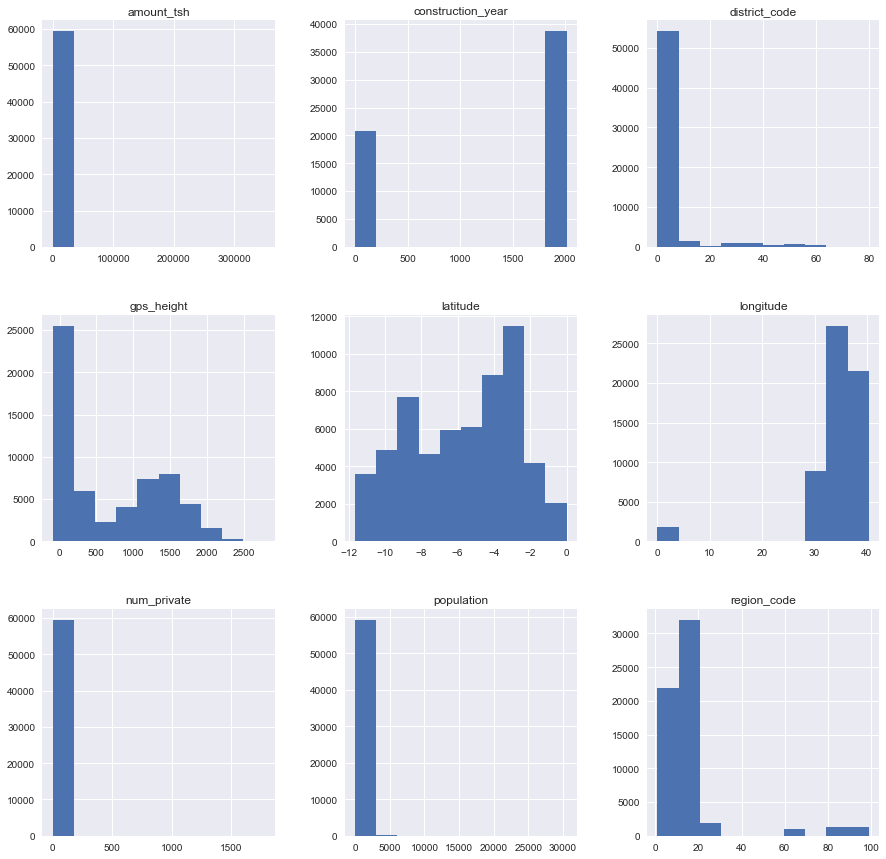

In [4]:
X_raw.hist(figsize=(15,15));

**Not too interesting, but there do seem to be some odd outliers in some**

The latitudes seem to be distributed in a reasonable way, but the longitudes look like they have a couple thousand zeros, which is probably not good

In [5]:
X_raw[X_raw.longitude == 0].shape

(1812, 40)

In every columns where long is zero, it seems like lat is near zero as well

In [6]:
X_raw[(X_raw.longitude == 0) & (X_raw.latitude == -2e-08)].shape

(1812, 40)

It looks like even though our latitude and longitude columns have no NaNs, we have 1812 entries where lat and long are ~0

**Remember** Tanzania's longitudes should be between 29 and 41, latitudes should be between -1 and -12

Now we can load in our shapefiles to make outlines of the country and its 30 regions:

In [7]:
tanz_map = geopandas.read_file('../data/shapefiles/TZA_adm0.shp')
tanz_regs = geopandas.read_file('../data/shapefiles/TZA_adm1.shp')

In our shapefiles folder we have the TZA_adm0.* files which outline the country, and the TZA_adm1.* files which outline the regions

I'm going to temporarily remove those (0,0) entries to get a sense for the rest of the map, and make the resulting set into a GeoDataFrame

In [8]:
# select only the points with valid lat+long
df_no0 = df.loc[df.longitude != 0]

# make GeoDataFrame
gdf = geopandas.GeoDataFrame(df_no0,
                geometry=geopandas.points_from_xy(df_no0.longitude, df_no0.latitude))

gdf

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,geometry
id,,,,,,,,,,,,,,,,,,,,,
69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,POINT (34.93809 -9.85632)
8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,POINT (34.69877 -2.14747)
34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,POINT (37.46066 -3.82133)
67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,POINT (38.48616 -11.15530)
19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,POINT (31.13085 -1.82536)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,POINT (37.16981 -3.25385)
27263,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,POINT (35.24999 -9.07063)
37057,functional,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,POINT (34.01709 -8.75043)


Let's put it all in a map

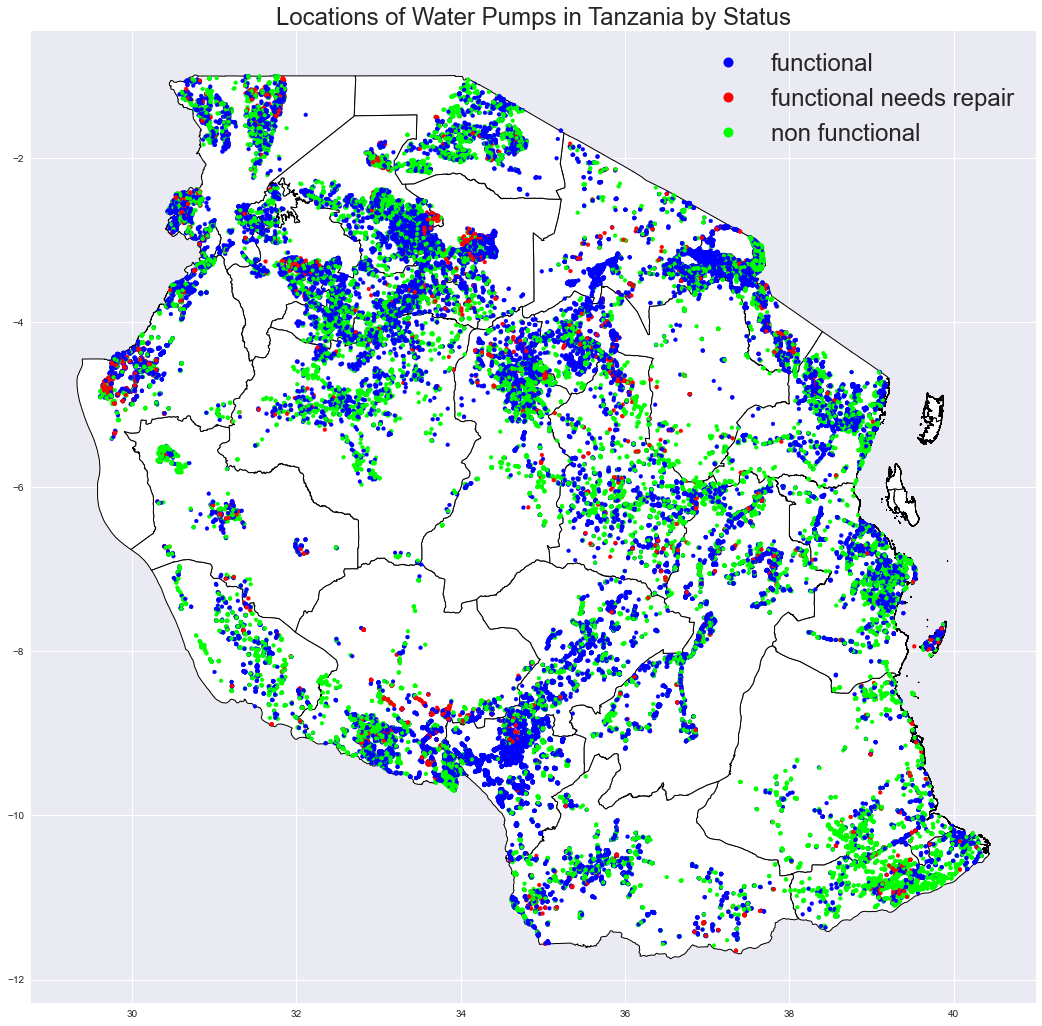

In [9]:
fig, ax = plt.subplots(figsize=(18,18))
ax.set_title('Locations of Water Pumps in Tanzania by Status',
             fontdict={'fontsize':24})

# plots outline of Tanzania
tanz_regs.plot(ax=ax, color='white',
              edgecolor='black', linewidth=1);

# plots locations of pumps on map, colored by status
gdf.plot(ax=ax, column=gdf.status_group,
         markersize=15, cmap='brg',
         legend=True, legend_kwds={'fontsize':24});

# save figure in data folder
#fig.savefig('../data/map_pump_status.png')

Visually, it doesn't seem like there's a huge correlation between geographic location in the country and pump status. Maybe there's a higher proportion of non-functional pumps in the south-eastern regions

I'll just try to see what other columns are intersting right now

In [10]:
df.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [11]:
df.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [12]:
df[df.quantity == df.quantity_group]

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
27263,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
37057,functional,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump


**Duplicate columns**
 - quantity / quantity_group
 - payment / payment_type